In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.neural_network import MLPRegressor
import torch
from torch.nn import *
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def prepare_data(df):
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col] * df['AdjustmentFactor']
    
    df.ExpectedDividend.fillna(0, inplace=True)
    df.drop(['AdjustmentFactor', 'RowId'], axis=1, inplace=True)
    df['SupervisionFlag'] = df['SupervisionFlag'].astype(int)
#     df['Year'] = df['Date'].dt.year.astype(float)
#     df['Month'] = df['Date'].dt.month.astype(float)
#     df['Week'] = df['Date'].dt.isocalendar().week.astype(float)
#     df['Day'] = df['Date'].dt.day.astype(float)
    
    
    df.sort_values(by=['SecuritiesCode','Date'], inplace=True)
    df['Open'].interpolate(inplace=True)
    df['High'].interpolate(inplace=True)
    df['Low'].interpolate(inplace=True)
    df['Close'].interpolate(inplace=True)
    df.loc[df['Volume'] == 0,"Volume"] = np.nan
    df['Volume'].interpolate(inplace=True)
    df['Target'].interpolate(inplace=True)
    
    return df

t = pd.read_csv("../jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv",
                parse_dates=["Date"])
t = prepare_data(t)

In [3]:
def create_diffs(df):
    d1 = lambda df,col: df[col].diff(periods=1)/(df[col] + 1e-8)

    for f in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df['diff' + f] = d1(df, f)
    df['pctDailyChange'] = (df['Close'] - df['Open'])/df['Close']
    df = df.dropna()
    return df

In [4]:
STOCK = t.loc[t['SecuritiesCode'] == 1376].reset_index(drop=True).copy()
STOCK = create_diffs(STOCK)

In [5]:
t = create_diffs(t)

In [6]:
secs = t.loc[t['Date'] == '2017-01-04',['SecuritiesCode']].values.squeeze(1)

In [7]:
df1 = t.loc[t['Date'] >= '2017-01-04'].set_index('SecuritiesCode')

In [8]:
df1 = df1.loc[df1.index.isin(secs)].copy()

In [9]:
dates = df1.Date.unique()
len(dates)

1202

In [28]:
#df1.loc[df1.Date == dates[0], ['diffClose', 'ExpectedDividend']].values.reshape(-1)

array([-4.22241681,  0.        ,  0.81775701, ...,  0.        ,
       -2.07069409,  0.        ])

In [30]:
features = ['ExpectedDividend', 'diffClose'] # 'diffOpen', 'diffHigh', 'diffLow', 'diffClose', 'diffVolume', 
           # 'pctDailyChange', 'ExpectedDividend']

target = 'Target'

In [31]:
X_test, y_test = [], []
X_train, y_train = [], []
history_size = 1 # training history
val_size = 100

for i in range(0, len(dates) - history_size - val_size):
    tmp = []
    for j in range(history_size):
        tmp.append(df1.loc[df1.Date == dates[i+j], [*features]].values.reshape(-1))
    X_train.append(*tmp)
    y_train.append(df1[(df1.index == 1376) & (df1.Date == dates[i + history_size - 1])]
                   [target].values[0])

for i in range(len(dates) - history_size - val_size, len(dates) - history_size):
    tmp = []
    for j in range(history_size):
        tmp.append(df1.loc[df1.Date == dates[i+j], [*features]].values.reshape(-1))
    X_test.append(*tmp)
    y_test.append(df1[(df1.index == 1376) & (df1.Date == dates[i + history_size - 1])]
                   [target].values[0])

In [13]:
# X_test, y_test = [], []
# X_train, y_train = [], []
# history_size = 1 # training history
# val_size = 100

# for i in range(0, len(STOCK) - history_size - val_size):
#     tmp = []
#     for j in range(history_size):
#         for f in features:
#             tmp.append(STOCK[f].iloc[i+j])
#     X_train.append(tmp)
#     y_train.append(STOCK[target_feature].iloc[i+history_size - 1])

# for i in range(len(STOCK) - history_size - val_size, len(STOCK) - history_size):
#     tmp = []
#     for j in range(history_size):
#         for f in features:
#             tmp.append(STOCK[f].iloc[i+j])
#     X_test.append(tmp)
#     y_test.append(STOCK[target_feature].iloc[i+history_size - 1])

In [32]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).unsqueeze(1)
 
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [33]:
batchSize=32
dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=False)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

In [34]:
class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        k = 5
        self.layer1 = Linear(n_inputs, k*n_inputs)
        self.layer2 = Linear(k*n_inputs, k*n_inputs)
        self.layer3 = Linear(k*n_inputs, 1)
        self.activation = LeakyReLU()
        self.dropout = Dropout(p=0.2)
        
 
    def forward(self, X):
        X = self.layer1(X)
        X = self.activation(X) + X
        
        X = self.dropout(X)
        X = self.layer2(X)
        X = self.activation(X) + X
        
        X = self.dropout(X)
        X = self.layer3(X)
        return X

In [38]:
model = MLP(len(features)*len(secs)).to(device)

In [40]:
criterion = torch.nn.L1Loss()   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, min_lr=1e-8, factor=0.5)

In [42]:
start_time = datetime.now()

for epoch in range(801):
    train_loss = 0
    model.train()
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        yhat = model(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    model.eval()
    
    if epoch % 10 == 0:    
        with torch.no_grad():
            eval_loss = 0
            y_pred = []
            for i, (inputs, targets) in enumerate(test_dl):
                inputs, targets = inputs.to(device), targets.to(device)
                yhat = model(inputs)
                y_pred.append(yhat.item())
                loss = criterion(yhat, targets)
                eval_loss += loss

        scheduler.step(eval_loss)
        if epoch % 10 == 0: 
            print("Epoch: " + str(epoch) + ", train loss: " + str(train_loss/len(train_dl)) + ", eval loss: " + str(eval_loss/len(test_dl)))

print(datetime.now() - start_time)

Epoch: 0, train loss: tensor(0.4180, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.2246, device='cuda:0')
Epoch: 10, train loss: tensor(0.4064, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1880, device='cuda:0')
Epoch: 20, train loss: tensor(0.5577, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1718, device='cuda:0')
Epoch: 30, train loss: tensor(0.3979, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.2213, device='cuda:0')


KeyboardInterrupt: 

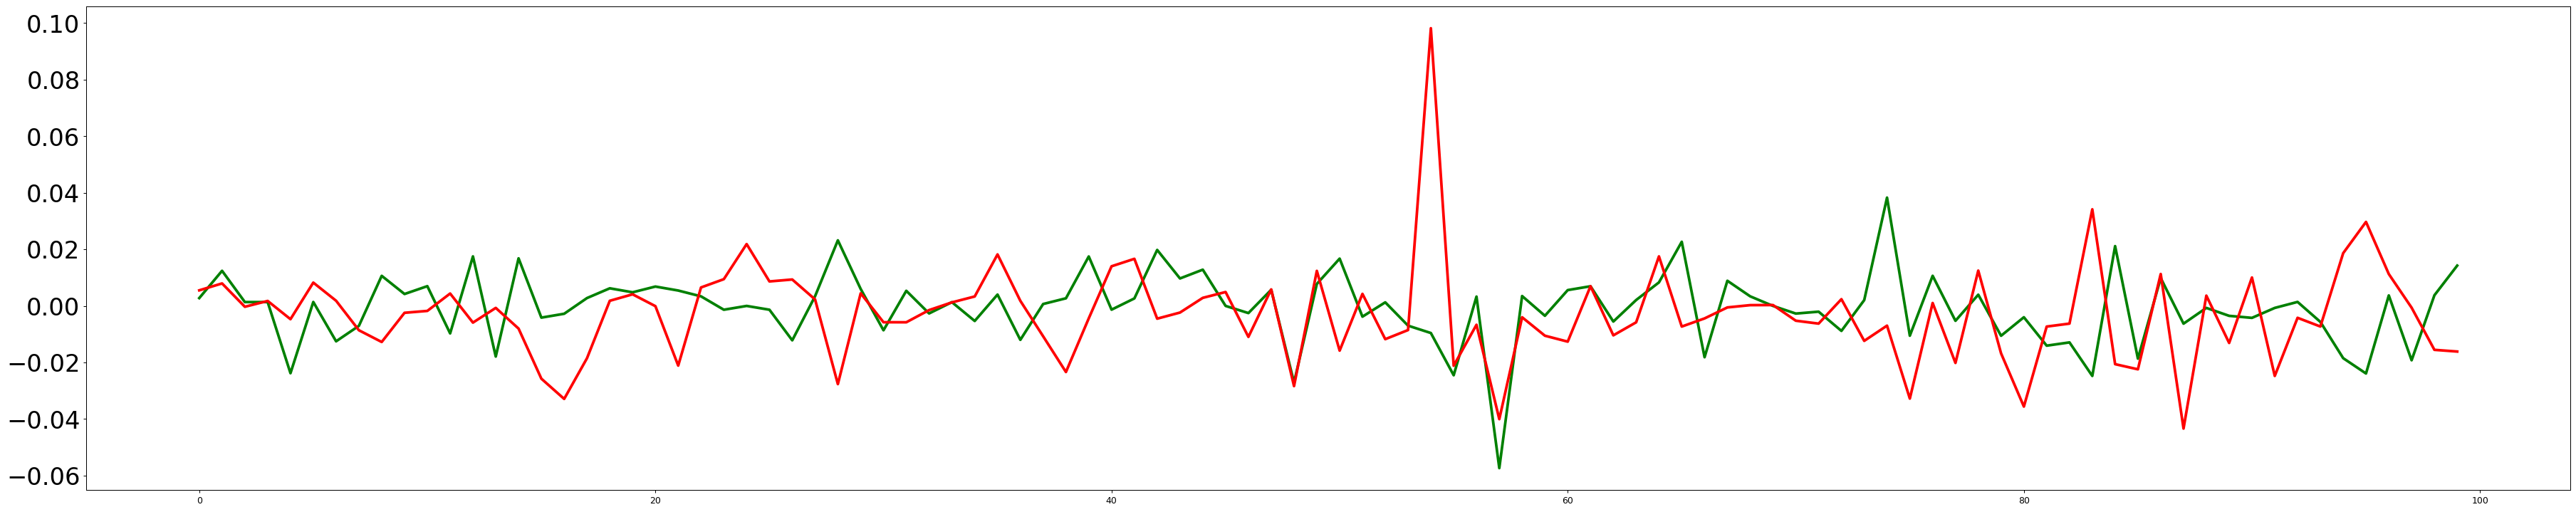

In [203]:
fig1, ax1 = plt.subplots(figsize=(50, 10), dpi=90)
ax1.tick_params(axis='y', which='both',    
                labeltop='on', labelbottom='off', labelsize=27)
ax1.plot(y_test, 'g', lw=3)
ax1.plot(y_pred,'r', lw=3)